In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-white')
plt.rc('figure', dpi=100, figsize=(7, 5))
plt.rc('font', size=12)

import warnings
warnings.simplefilter('ignore')

# Lecture 26 – Examples and Classifier Evaluation

## DSC 80, Spring 2022

### Announcements

- Lab 9 is due on **Tuesday, May 31st at 11:59PM** (note the later deadline).
- Project 5 is released, and is due on **Thursday, June 9th at 11:59PM**!
    - Open-ended, and uses the same datasets as Project 3.
    - **No checkpoint, and no slip days allowed!**
- If at least 80% of the class fills out both [CAPEs](https://cape.ucsd.edu/) and the [End-of-Quarter Survey](https://docs.google.com/forms/d/e/1FAIpQLSepSEBy0KC1-RHGF6dixYKZ-2p3SVdiPHB9spXPlA6PZNUy4A/viewform), then everyone will receive an extra 0.5% added to their overall course grade.
- Project 3 and Lab 8 grades are released.
- The Final Exam is on **Saturday, June 4th from 11:30AM-2:30PM in-person**!
    - You may bring 2 two-sided cheat sheets.
    - **Everything in the Lecture 26 notebook is in scope**, and it is the last lecture that is in scope.
    - Expect a walkthrough video of the [Fall 2021 final](https://dsc80.com/resources/) by Tuesday.
    - More details soon.
   

### Agenda
- One-hot encoding and multicollinearity.
- Modeling with text features.
- Classifier evaluation.

## One-hot encoding and multicollinearity

### One-hot encoding and multicollinearity

When we one-hot encode categorical features, we create several **redundant** columns.

In [ ]:
tips = sns.load_dataset('tips')
tips_features = tips.drop('tip', axis=1)
tips_features.head()

Aside: You can use `pd.get_dummies` in EDA, but **don't** use it for modeling (instead, use `OneHotEncoder`, which works with `Pipeline`s).

In [ ]:
X = pd.get_dummies(tips_features)
X.head()

Remember that under the hood, `LinearRegression()` creates a **design matrix** that has a column of all ones (for the intercept term). Let's add that column above for demonstration.

In [ ]:
X['all_ones'] = 1
X.head()

Now, many of the above columns **can be written as linear combinations of other columns**!
- We don't need `'sex_Male'` – its value is just `'all_ones'` - `'sex_Female'`.
- We don't need `'smoker_Yes'` – its value is just `'all_ones'` - `'smoker_No'`.
- We don't need `'time_Lunch'` – its value is just `'all_ones'` - `'time_Dinner'`.
- We don't need `'day_Thur'` – its value is just `'all_ones'` - (`'day_Fri'` + `'day_Sat'` + `'day_Sun'`).

Note that if we get rid of the four redundant columns above, the **rank** of our design matrix – that is, the number of linearly independent columns it has – does not change (and so the "predictive power" of our features doesn't change either).

In [ ]:
np.linalg.matrix_rank(X)

In [ ]:
np.linalg.matrix_rank(X.drop(columns=['sex_Male', 'smoker_Yes', 'time_Lunch', 'day_Thur']))

However, without the redundant columns, there is only a single unique set of optimal parameters $w^*$, and the multicollinearity is no more.

**Aside:** Most one-hot encoding techniques (including `OneHotEncoder`) have an in-built `drop` argument, which allow you to specify that you'd like to drop **one column per categorical feature**.

In [ ]:
pd.get_dummies(tips_features, drop_first=True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe = OneHotEncoder(drop='first')
ohe.fit_transform(tips_features[['sex', 'smoker', 'day', 'time']]).toarray()

In [ ]:
ohe.get_feature_names()

The above array only has $(2-1) + (2-1) + (4-1) + (2-1) = 6$ columns, rather than $2 + 2 + 4 + 2 = 10$, since we dropped 1 per categorical column in `tips_features`.

### Key takeaways

- Multicollinearity is present in a linear model when one feature can be accurately predicted using one or more other features.
    - In other words, it is present when a feature is **redundant**.
- Multicollinearity doesn't pose an issue for prediction; it doesn't hinder a model's ability to generalize. Instead, it renders the **coefficients** of a linear model meaningless.
- Multicollinearity is present when performing one-hot encoding; a solution is to drop **one one-hot-encoded column for each original categorical feature**.

## Modeling using text features

### Example: Predicting reviews

We have a dataset containing Amazon reviews and ratings for patio, lawn, and gardening products. (Aside: [Here](https://jmcauley.ucsd.edu/data/amazon/) is a good source for such data.)

In [ ]:
reviews = pd.read_json(open('data/reviews.json'), lines=True)
reviews.head()

**Goal:** Use a review's `'summary'` to predict its `'overall'` rating.

Note that there are five possible `'overall'` rating values – 1, 2, 3, 4, 5 – not just two. As such, this is an instance of **multiclass classification**.

In [ ]:
reviews['overall'].value_counts(normalize=True)

**Question:** What is the worst possible accuracy we should expect from a ratings classifier, given the above distribution?

### Aside: `CountVectorizer`

Entries in the `'summary'` column are not currently quantitative! We can use the bag-of-words encoding to create quantitative features out of each `'summary'`. Instead of performing a bag-of-words encoding manually as we did before, we can rely on `sklearn`'s `CountVectorizer`.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
example_corp = ['hey hey hey my name is billy', 
                'hey billy how is your dog billy']

In [ ]:
count_vec = CountVectorizer()
count_vec.fit(example_corp)

`count_vec` learned a **vocabulary** from the corpus we `fit` it on.

In [ ]:
count_vec.vocabulary_

In [ ]:
count_vec.transform(example_corp).toarray()

Note that the values in `count_vec.vocabulary_` correspond to the positions of the columns in `count_vec.transform(example_corp).toarray()`, i.e. `'billy'` is the first column and `'your'` is the last column.

In [ ]:
example_corp

In [ ]:
pd.DataFrame(count_vec.transform(example_corp).toarray(),
             columns=pd.Series(count_vec.vocabulary_).sort_values().index)

### Creating an initial `Pipeline`

Let's build a `Pipeline` that takes in summaries and overall ratings and:
- Uses `CountVectorizer` to quantitatively encode summaries.
- Fits a `RandomForestClassifier` to the data.
    - A "random forest" is a combination (or **ensemble**) of decision trees, each fit on a different **bootstrapped** resample of the training data.
    - It makes predictions by aggregating the results of the individual trees (in the case of classification, by taking the **most common prediction**).

But first, a train-test split (like **always**).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = reviews['summary']
y = reviews['overall']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
pl = Pipeline([
    ('cv', CountVectorizer()), 
    ('clf', RandomForestClassifier(max_depth=8, n_estimators=7)) # Uses 7 separate decision trees
])

In [ ]:
pl.fit(X_train, y_train)

In [ ]:
# Training accuracy
pl.score(X_train, y_train)

In [ ]:
# Testing accuracy
pl.score(X_test, y_test)

The accuracy of our random forest is just above 50%, on both the training and testing sets. This doesn't seem much better than just predicting "5 stars" every time!

In [ ]:
len(pl.named_steps['cv'].vocabulary_) # Many features, but we are not asking many questions!

### Choosing tree depth via `GridSearchCV`

We arbitrarily chose `max_depth=8` before, but it seems like that isn't working well. Let's perform a grid search to find the `max_depth` with the best generalization performance.

In [ ]:
pl.named_steps

In [ ]:
# Note that we've used the key clf__max_depth, not max_depth
# because max_depth is a hyperparameter of clf, not of pl

hyperparameters = {
    'clf__max_depth': np.arange(2, 500, 20)
}

Note that while `pl` has already been `fit`, we can still give it to `GridSearchCV`, which will repeatedly re-`fit` it during cross-validation.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Takes 10+ seconds to run – how many trees are being trained?
grids = GridSearchCV(pl, param_grid=hyperparameters, return_train_score=True)
grids.fit(X_train, y_train)

In [ ]:
grids.best_params_

Recall, `fit` `GridSearchCV` objects are estimators on their own as well. This means we can compute the training and testing accuracies of the "best" random forest directly:

In [ ]:
# Training accuracy
grids.score(X_train, y_train)

In [ ]:
# Testing accuracy
grids.score(X_test, y_test)

Still not much better on the testing set! 🤷

### Training and validation accuracy vs. depth

Below, we plot how training and validation accuracy varied with tree depth. Note that the $y$-axis here is accuracy, and that larger accuracies are better (unlike with RMSE, where smaller was better).

In [ ]:
index = grids.param_grid['clf__max_depth']
train = grids.cv_results_['mean_train_score']
valid = grids.cv_results_['mean_test_score']

In [ ]:
pd.DataFrame({'train': train, 'valid': valid}, index=index).plot()
plt.xlabel('Depth')
plt.ylabel('Accuracy');

Unsurprisingly, training accuracy kept increasing, while validation accuracy leveled off around a depth of ~100.

## Classifier evaluation

### Accuracy isn't everything!

$$\text{accuracy} = \frac{\text{# data points classified correctly}}{\text{# data points}}$$

* Accuracy is defined as the proportion of predictions that are correct.

* It weighs all **correct** predictions the same, and weighs all **incorrect** predictions the same.

* But some incorrect predictions may be worse than others!
    - Example: Suppose you take a COVID test 🦠. Which is worse:
        - The test **saying you have COVID**, when you really don't, or
        - The test **saying you don't have COVID**, when you really do?

### The Boy Who Cried Wolf 👦😭🐺 

([source](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative))

> A shepherd boy gets bored tending the town's flock. To have some fun, he cries out, "Wolf!" even though no wolf is in sight. The villagers run to protect the flock, but then get really mad when they realize the boy was playing a joke on them.

Repeat the previous paragraph many, many times.

> One night, the shepherd boy sees a real wolf approaching the flock and calls out, "Wolf!" The villagers refuse to be fooled again and stay in their houses. The hungry wolf turns the flock into lamb chops. The town goes hungry. Panic ensues.



### The wolf classifier

* Predictor: Shepherd boy.
* Positive prediction: "There is a wolf."
* Negative prediction: "There is no wolf."

Some questions to think about:

- What is an example of an incorrect, positive prediction?

- Was there a correct, negative prediction?

- There are four possibilities. What are the consequences of each?
    - (predict yes, predict no) x (actually yes, actually no). 

### The wolf classifier

Below, we present a **confusion matrix**, which summarizes the four possible outcomes of the wolf classifier.

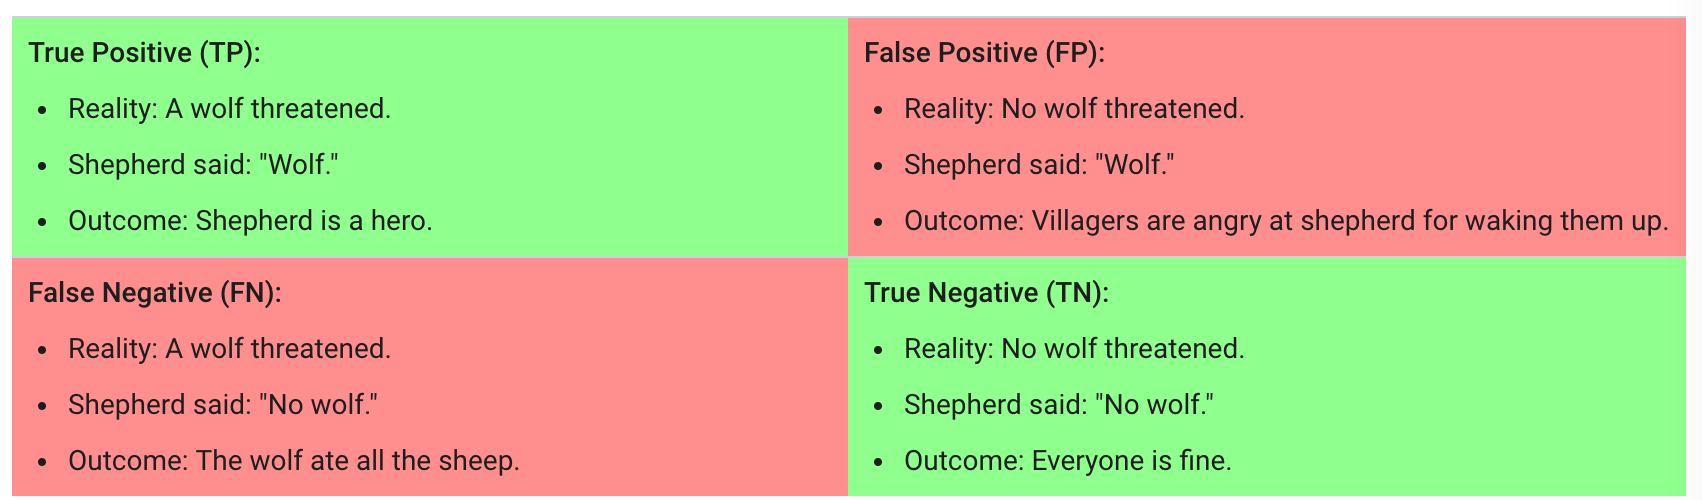

### Outcomes in binary classification

When performing **binary** classification, there are four possible outcomes. 

(Note: A "positive prediction" is a prediction of 1, and a "negative prediction" is a prediction of 0.)

|Outcome of Prediction|Definition|True Class|
|---|---|---|
|**True** positive (TP) ✅|The predictor **correctly** predicts the positive class.|P|
|False negative (FN) ❌|The predictor incorrectly predicts the negative class.|P|
|**True** negative (TN) ✅|The predictor **correctly** predicts the negative class.|N|
|False positive (FP) ❌|The predictor incorrectly predicts the positive class.|N|

<center>⬇️</center>

| | Predicted Negative | Predicted Positive |
| --- | --- | --- |
| **Actually Negative** | TN ✅ | FP ❌ |
| **Actually Positive** | FN ❌ | TP ✅ |

<br>

<center><i>The <b>confusion matrix</b> above is organized the same way that <code>sklearn</code>'s confusion matrices are (but differently than in the wolf example).</i></center>

Note that in the four acronyms – TP, FN, TN, FP – the **first letter** is whether the prediction is correct, and the **second letter** is what the prediction is.

### Example: COVID testing 🦠

- UCSD Health administers hundreds of COVID tests a day. The tests are not fully accurate.
- Each test comes back either
    - positive, indicating that the individual has COVID, or
    - negative, indicating that the individual does not have COVID.
- **Question:** What is a TP in this scenario? FP? TN? FN?

- **TP:** The test predicted that the individual has COVID, and they do ✅. 


- **FP:** The test predicted that the individual has COVID, but they don't ❌.

- **TN:** The test predicted that the individual doesn't have COVID, and they don't ✅.

- **FN:** The test predicted that the individual doesn't have COVID, but they do ❌.

### Accuracy of COVID tests

The results of 100 UCSD Health COVID tests are given below.

| | Predicted Negative | Predicted Positive |
| --- | --- | --- |
| **Actually Negative** | TN = 90 ✅ | FP = 1 ❌ |
| **Actually Positive** | FN = 8 ❌ | TP = 1 ✅ |

<center><i><small>UCSD Health test results</small></i></center>

🤔 **Question:** What is the accuracy of the test?

**🙋 Answer:** $$\text{accuracy} = \frac{TP + TN}{TP + FP + FN + TN} = \frac{1 + 90}{100} = 0.91$$

- **Followup:** At first, the test seems good. But, suppose we build a classifier that predicts that **nobody has COVID**. What would its accuracy be?

- **Answer to followup:** Also 0.91! There is severe **class imbalance** in the dataset, meaning that most of the data points are in the same class (no COVID). Accuracy doesn't tell the full story.

### Recall

| | Predicted Negative | Predicted Positive |
| --- | --- | --- |
| **Actually Negative** | TN = 90 ✅ | FP = 1 ❌ |
| <span style='color:orange'><b>Actually Positive</b></span> | <span style='color:orange'>FN = 8</span> ❌ | <span style='color:orange'>TP = 1</span> ✅ |

<center><i><small>UCSD Health test results</small></i></center>

🤔 **Question:** What proportion of individuals who actually have COVID did the test **identify**?

**🙋 Answer:** $\frac{1}{1 + 8} = \frac{1}{9} \approx 0.11$

More generally, the **recall** of a binary classifier is the proportion of <span style='color:orange'><b>actually positive instances</b></span> that are correctly classified. We'd like this number to be as close to 1 (100%) as possible.

$$\text{recall} = \frac{TP}{TP + FN}$$

To compute recall, look at the <span style='color:orange'><b>bottom (positive) row</b></span> of the above confusion matrix.

### Recall isn't everything, either!

$$\text{recall} = \frac{TP}{TP + FN}$$

🤔 **Question:** Can you design a "COVID test" with perfect recall?

**🙋 Answer:** Yes – **just predict that everyone has COVID!**

| | Predicted Negative | Predicted Positive |
| --- | --- | --- |
| **Actually Negative** | TN = 0 ✅ | FP = 91 ❌ |
| <span style='color:orange'><b>Actually Positive</b></span> | <span style='color:orange'>FN = 0</span> ❌ | <span style='color:orange'>TP = 9</span> ✅ |

<center><i><small>everyone-has-COVID classifier</small></i></center>


$$\text{recall} = \frac{TP}{TP + FN} = \frac{9}{9 + 0} = 1$$

Like accuracy, recall on its own is not a perfect metric. Even though the classifier we just created has perfect recall, it has 91 false positives!

### Precision

| | Predicted Negative | <span style='color:orange'>Predicted Positive</span> |
| --- | --- | --- |
| **Actually Negative** | TN = 0 ✅ | <span style='color:orange'>FP = 91</span> ❌ |
| **Actually Positive** | FN = 0 ❌ | <span style='color:orange'>TP = 9</span> ✅ |

<center><i><small>everyone-has-COVID classifier</small></i></center>


The **precision** of a binary classifier is the proportion of <span style='color:orange'><b>predicted positive instances</b></span> that are correctly classified. We'd like this number to be as close to 1 (100%) as possible.

$$\text{precision} = \frac{TP}{TP + FP}$$

To compute precision, look at the <span style='color:orange'><b>right (positive) column</b></span> of the above confusion matrix.

- **Tip:** A good way to remember the difference between precision and recall is that in the denominator for 🅿️recision, both terms have 🅿️ in them (TP and FP).

- Note that the "everyone-has-COVID" classifier has perfect recall, but a precision of $\frac{9}{9 + 91} = 0.09$, which is quite low.

- 🚨 **Key idea:** There is a "tradeoff" between precision and recall. For a particular prediction task, one may be important than the other.

### Precision and recall

<center><img src="imgs/Precisionrecall.svg.png" width=30%></center>

<center>(<a href="https://en.wikipedia.org/wiki/Precision_and_recall">source</a>)</center>

### Precision and recall

$$\text{precision} = \frac{TP}{TP + FP} \: \: \: \:  \: \: \: \: \text{recall} = \frac{TP}{TP + FN}$$

🤔 **Question:** When might high **precision** be more important than high recall?

**🙋 Answer:** For instance, in deciding whether or not someone committed a crime. Here, **false positives are really bad** – they mean that an innocent person is charged!

🤔 **Question:** When might high **recall** be more important than high precision?

**🙋 Answer:** For instance, in medical tests. Here, **false negatives are really bad** – they mean that someone's disease goes undetected!

### Discussion Question

Consider the confusion matrix shown below.

| | Predicted Negative | Predicted Positive |
| --- | --- | --- |
| **Actually Negative** | TN = 22 ✅ | FP = 2 ❌ |
| **Actually Positive** | FN = 23 ❌ | TP = 18 ✅ |

What is the accuracy of the above classifier? The precision? The recall?

<br>

After calculating all three on your own, click below to see the answers.

<details>
    <summary>Accuracy</summary>
    (22 + 18) / (22 + 2 + 23 + 18) = 40 / 65
</details>

<details>
    <summary>Precision</summary>
    18 / (18 + 2) = 9 / 10
</details>

<details>
    <summary>Recall</summary>
    18 / (18 + 23) = 18 / 41
</details>    

## Summary, next time

### Summary

- See the "Key takeaways" of the multicollinearity section for a section summary.
- The `CountVectorizer` transformer can be used to perform the bag-of-words encoding.
- Accuracy alone is not always a meaningful representation of a classifier's quality, particularly when the **classes are imbalanced**.
    - Precision and recall are classifier evaluation metrics that consider the **types of errors** being made.
    - There is a "tradeoff" between precision and recall. One may be more important than the other, depending on the task.
- **Next time:** How to weigh precision and recall when training a classifier. Other metrics. Fairness.